In [ ]:
# default_exp embed
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import FRED
from FRED.embed import *
if torch.__version__[:4] == '1.13': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
%load_ext autoreload
%autoreload 2

finding diffusion operator
Set sigma =  0.030807637
Powering diffusion operator


  0%|          | 0/3 [00:00<?, ?it/s]

computing diffusion distances


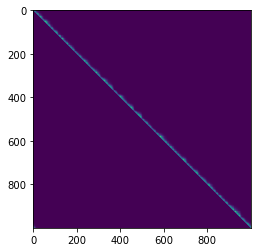

In [ ]:
from FRED.datasets import directed_circle
X, flows, labels = directed_circle(num_nodes=1000)
ds = FlowPredictionDataset(X, flows, labels)
from torch.utils.data import DataLoader
dataloader = DataLoader(ds, batch_size=2000, num_workers=0)

# 03e Flow Prediction Network

In [ ]:
# export
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm
from FRED.data_processing import flashlight_affinity_matrix, diffusion_map_from_affinities, flow_neighbors
class FlowPredictionDataset(Dataset):
    """
    Dataset object to be used with FRED for pointcloud and velocity input data.
    Takes np.arrays for X (points) and velocities (velocity vectors per point).
    For each item retrieved, returns a neighborhood around that point (based on local euclidean neighbors) containing local affinities

    """
    def __init__(self, 
                X, 
                velocities, 
                labels, 
                sigma="automatic", 
                ts = (1,2,4,8),
                prior_embedding = "diffusion map", 
                t_dmap = 1, 
                dmap_coords_to_use = 2,):
        # Step 0: Convert data into tensors
        self.X = torch.tensor(X).float()
        self.velocities = torch.tensor(velocities).float()
        self.labels = labels
        self.n_nodes = self.X.shape[0]
        self.eps = 1e-3
        # Step 1. Build graph on input data, using flashlight kernel
        print("finding diffusion operator")
        self.A = flashlight_affinity_matrix(self.X, self.velocities, sigma = sigma)
        self.A[self.A < self.eps] = 0
        # visualize affinity matrix
        plt.imshow(self.A.numpy())
        # Construct diffusion matrix as row normalized adjacency matrix
        self.P_graph = F.normalize(self.A, p=1, dim=1)
        # threshold values less than epsilon to zero
        # We convert P_graph into sparse format to efficiently power
        self.P_graph = self.P_graph.to_sparse().coalesce()
        # Compute powers of P (really fast, because it's sparse : ) 
        self.P_graph_ts = [self.P_graph]
        print("Powering diffusion operator")
        for t in tqdm(ts[1:]):
            # TODO Can make more efficient by using prior powers
            powered_matrix = torch.linalg.matrix_power(self.P_graph_ts[0], t).coalesce()
            dense_powered = powered_matrix.to_dense()
            dense_powered[dense_powered < self.eps] = 0
            sparse_powered = dense_powered.to_sparse()
            self.P_graph_ts.append(sparse_powered)
            # TODO: Could proactively prune probs below eps threshold here.


        # Step 2. Take a diffusion map of the data
        # These will become our 'precomputed distances' which we use to regularize the embedding
        if prior_embedding == "diffusion map":
            print("computing diffusion distances")
            P_dense = self.P_graph.clone().to_dense()
            P_graph_symmetrized = P_dense + P_dense.T
            diff_map = diffusion_map_from_affinities(
                # TODO: May need to convert back to dense form.
                P_graph_symmetrized, t=t_dmap, plot_evals=False 
            )
            self.diff_coords = diff_map[:, :dmap_coords_to_use]
            self.diff_coords = self.diff_coords.real
            self.diff_coords = torch.tensor(self.diff_coords.copy()).float()
            self.precomputed_distances = torch.cdist(self.diff_coords, self.diff_coords)
            # scale distances between 0 and 1
            self.precomputed_distances = 2 * (
                self.precomputed_distances / torch.max(self.precomputed_distances)
            )
            self.precomputed_distances = (
                self.precomputed_distances.detach()
            )  # no need to have gradients from this operation
        
        # Step 3. Decompose the affinity matrix into a list of indices [i,j], which we use to form batches
        # To prevent this from making the batch have size n x n, we use the *nonzero* indices of the 
        # sparse powered diffusion matrices.
        # But each powered diffusion matrix will have different nonzero values. Hence, we want the union of all relationships which
        # at some level of diffusion, are nonzero
        # print("sparse Pts are",self.P_graph_ts)
        all_P_values = self.P_graph_ts[0]
        for i in range(1,len(ts)):
            # print(i)
            all_P_values += all_P_values + self.P_graph_ts[i]
            all_P_values = all_P_values.coalesce()
        self.diffusion_indices = all_P_values.indices() 
        # returns matrix whose columns are indices
        # tensor([[0, 1, 1],
        #         [2, 0, 2]])
        # convert to matrix whose rows are indices
        self.diffusion_indices = self.diffusion_indices.transpose(0,1)
    def __len__(self):
        return len(self.diffusion_indices)
    def __getitem__(self, idx):
        # idx specifies the ith tuple of points in the diffusion indices.
        happy_couple = self.diffusion_indices[idx]
        # print("hc is",happy_couple)
        # Construct diffusion probabilities into a list of tensors
        probs = torch.zeros(len(self.P_graph_ts))
        transition_to = torch.zeros(len(self.P_graph_ts))
        for i, Pt in enumerate(self.P_graph_ts):
            probs[i] = Pt[happy_couple[0]][happy_couple[1]]
            transition_to[i] = (probs[i] > 0.5).to(int)
        # print("got Pt probs just fine")
        # print("first sum worked")
        # Fetch points from X
        points = self.X[happy_couple]
        # print("got points just fine")
        # Embed these into a dictionary for easy cross reference
        return_dict = {
            "idxs":happy_couple,
            "probs":probs,
            "transition_to": transition_to,
            "distance":self.precomputed_distances[happy_couple[0]][happy_couple[1]],
            "X":points,
        }
        return return_dict

# The Network

In [ ]:
from FRED.data_processing import diffusion_map_from_points
class FixedDiffusionMapEmbedding(nn.Module):
    """
    Computes the diffusion map of the provided data.
    If `precompute = True`, computes diffusion map of input graph when initialized
    and returns this map whenever called (assuming that all subsequent input points
    are the same as initially)
    When false, dynamically computes diffusion map on passed points.
    (False is not yet implemented.)
    """

    def __init__(
        self,
        X,
        t=1,
        k=8,
        precompute=True,
        embedding_dimension=2,
        device=torch.device("cpu"),
        **kwargs
    ):
        super().__init__()
        self.t = t
        self.device = device
        # create diffusion map (building off of numpy array of points; this doesn't have to be differentiable)
        X = X.clone().cpu().numpy()
        diff_map = diffusion_map_from_points(X, k=k, t=t)
        self.diff_coords = diff_map[:, :embedding_dimension]
        self.diff_coords = self.diff_coords.real
        # scale to be between 0 and 1
        self.diff_coords = 2 * (self.diff_coords / np.max(self.diff_coords))
        self.diff_coords = torch.tensor(self.diff_coords.copy())
        self.diff_coords = self.diff_coords.to(device)

    def forward(self, X, idxs=None, **kwargs):
        if idxs is not None:
            return self.diff_coords[idxs]
        else:
            return self.diff_coords

using sigma =  0.023953762


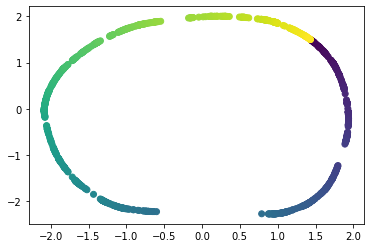

In [ ]:
X = torch.tensor(X).float()
fixed_diffmap_embedder = FixedDiffusionMapEmbedding(X, 1, device=device)
dmap = fixed_diffmap_embedder(X,torch.arange(len(X)))
plt.scatter(dmap[:,0],dmap[:,1], c=labels)

In [ ]:
fixed_diffmap_embedder.diff_coords[torch.tensor([1,2,3,4])].shape

torch.Size([4, 2])

In [ ]:
dmap.shape

torch.Size([1000, 2])

In [ ]:
# export
import torch
import torch.nn as nn
from FRED.data_processing import affinity_matrix_from_pointset_to_pointset

class FlowPredictionEmbedder(torch.nn.Module):
    def __init__(
        self,
        embedding_dimension=2,
        ts = [1,2,4,8],
        embedder_shape=[3, 4, 8, 4, 2],
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        sigma=0.5,
        flow_strength=0.5,
        smoothness_grid=True,
    ):
        super().__init__()
        self.device = device
        self.embedding_dimension = embedding_dimension
        # embedding parameters
        self.sigma = sigma
        self.flow_strength = flow_strength
        self.smoothness_grid = smoothness_grid
        self.ts = ts
        self.t_weights = [1,0.5,0.25,0.125]
        # Initialize autoencoder and flow artist

        # self.embedder, self.decoder = auto_encoder(embedder_shape, device=self.device)
        self.embedder = fixed_diffmap_embedder
        self.flowArtist = flow_artist(dim=self.embedding_dimension, device=self.device)
        # # training ops
        # self.KLD = nn.KLDivLoss(reduction="batchmean", log_target=False)
        self.MSE = nn.MSELoss()
        # self.KLD = homemade_KLD # when running on mac
        self.epsilon = 1e-6  # set zeros to eps
        # self.log_softmax = nn.LogSoftmax()
        self.loss = nn.BCELoss()

    def diffusion_flow_probs(self):
        # Predict flow probabilities to points based on a local diffusion matrix, constructed out of the batch
        # Penalize by cross entropy against expected probabilities
        # We use the embedded points and our FlowArtist to predict diffusion probabilities
        # Steps:
        # 1. Build diffusion matrix (using automatic kernel selection with flashlight kernel)
        A = affinity_matrix_from_pointset_to_pointset(self.embedded_points, self.embedded_points, self.embedded_flows, sigma=0.5, flow_strength=1)
        P = F.normalize(A, p=1, dim=1)
        # 2. Power diffusion matrix
        self.Pts = [torch.linalg.matrix_power(P,t) for t in self.ts]
        # 3. Convert from powered pointwise probs to the probs between pairs of points, in the format originally given.
        diffusion_probs = []
        for Pt in self.Pts:
            diffusion_probs.append(
                Pt.diagonal(offset = 1)[torch.arange(len(self.embedded_points)//2)*2]
            )
        return diffusion_probs
        
    def forward(self, data, loss_weights):
        # Extract data from batch
        # By default, point positions are batched two at a time. 
        # We need to flatten along the second dimension
        # # print data shapes
        # for k in data.keys():
        #     print(f"{k} shape {data[k].shape}")
        X = data["X"].flatten(start_dim=0, end_dim=1)
        embedding_idxs = data['idxs'].flatten()
        self.embedded_points = self.embedder(X, embedding_idxs)
        self.embedded_flows = self.flowArtist(self.embedded_points)
        # Compute Losses
        losses = {}
        # Compute predicted diffusion flow probabilities
        diffusion_probs = self.diffusion_flow_probs()
        y = data["transition_to"]
        # Loop through each t and compute a weighted multiscale loss
        cost = 0
        for i, t in enumerate(self.ts):
            cost += self.loss(diffusion_probs[i],y[:,i]) * self.t_weights[i]
        # print("predicted ",diffusion_probs[0])
        # print("actually ", y[:,0])
        losses["flow prediction"] = cost

        # Get autoencoder loss
        # X_reconstructed = self.decoder(self.embedded_points)
        # losses["reconstruction"] = self.MSE(X_reconstructed, X)
        return losses

In [ ]:
# dps = d["X"]
# dps

In [ ]:
# dps.flatten(start_dim=0,end_dim=1)

# Example in Usage

In [ ]:
# initialize model parameters and layers
from FRED.trainers import save_embedding_visualization, visualize_points, Trainer
title = "Flow Prediction Loss"
FPE = FlowPredictionEmbedder(
    device = device
).to(device)
loss_weights = {
            "flow prediction": 1,
            # "reconstruction":1,
        }
visualization_functions = [
    save_embedding_visualization,
    visualize_points
]
FREDtrainer = Trainer(FE = FPE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title, data_type="Flow Prediction")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

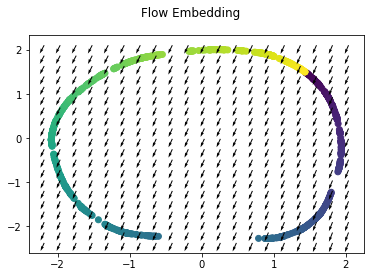

  0%|          | 0/41 [00:00<?, ?it/s]

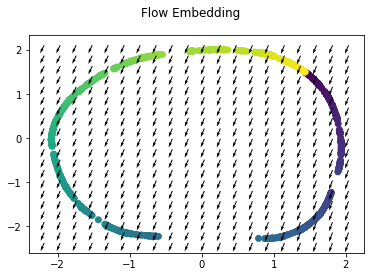

  0%|          | 0/41 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
FREDtrainer.fit(dataloader, n_epochs = 50)

In [ ]:
list(FREDtrainer.FE.embedded_points)

[tensor([-1.7755,  0.4771]),
 tensor([-1.5463,  1.0319]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.5462,  1.0321]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.5435,  1.0360]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.5424,  1.0376]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.5345,  1.0491]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.5302,  1.0553]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.5207,  1.0688]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.5197,  1.0701]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.5153,  1.0762]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.5117,  1.0811]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.5022,  1.0939]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.4934,  1.1057]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.4884,  1.1121]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.4867,  1.1142]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.4862,  1.1148]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.4860,  1.1151]),
 tensor([-1.7755,  0.4771]),
 tensor([-1.4803,  1.1223]),
 tensor([-1.77

In [ ]:
FREDtrainer.visualize_embedding()

AttributeError: 'Trainer' object has no attribute 'embedded_points'

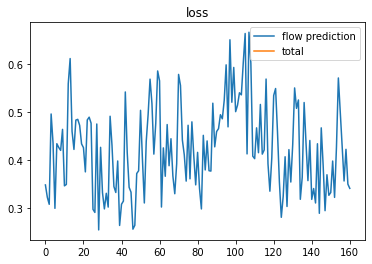

In [ ]:
FREDtrainer.visualize_loss()